# Compute advanced stats for song bouts

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from aux import get_seg
from disp import set_font_size, get_line
from time_stats import xcov_multi_with_confidence

cc = np.concatenate

SONG_FILE = 'data/simple/c_songs.npy'
COLORS = [(.75, .75, .75), 'b', 'r', (1, .5, 0)]

In [2]:
tmp = np.load(SONG_FILE, allow_pickle=True)[0]
songs = tmp['songs']
dt = tmp['dt']
fps = tmp['fps']

In [3]:
durs = dt*np.array([len(s) for s in songs])
m_cpln = ~(durs == durs.max())

In [4]:
def plot_s(ax, t, s, extent, c, t_bar=1):
    """
    Note: extent: [x_min, x_max, y_min, y_max]
    """
    x_0 = extent[0]
    dx = (extent[1] - extent[0]) / len(s)
    modes = range(4)
    for mode in modes:
        bds = get_seg(s==mode, min_gap=1)[1]
        for istart, iend in bds:
            ax.fill_between([x_0+dx*istart, x_0+dx*iend], 2*[extent[2]], 2*[extent[3]], color=c[mode])
            
    dt = np.mean(np.gradient(t))
    dy_scale = .2*(extent[3]-extent[2])
    ax.fill_between([x_0, x_0+dx/dt*t_bar], 2*[extent[3] + 2*dy_scale], 2*[extent[3] + 3*dy_scale], color='k')
    return ax

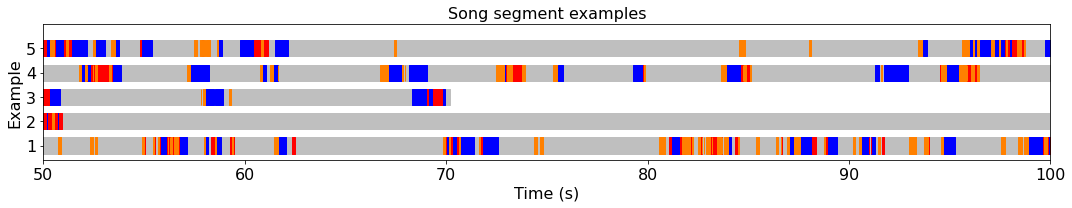

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3), tight_layout=True)

y_ticks = []
for cs, isong in enumerate(range(5)):
    s = songs[isong]
    t = np.arange(len(s))*dt
    plot_s(ax, t, s, extent=[0, len(s)*dt, 1.5*cs, 1.5*cs+1], c=COLORS, t_bar=0)
    y_ticks.append(1.5*cs + .5)

ax.set_xlim(50, 100)
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.arange(len(y_ticks))+1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Example')
ax.set_title('Song segment examples')

set_font_size(ax, 16)

# Identify bouts preceded by long silence

45745 bouts with 0.075 second minimum gap.
1428363 time points in total.
23614 bouts with 0.5 second minimum gap.
1536026 time points in total.
18115 bouts with 1 second minimum gap.
1651718 time points in total.
12642 bouts with 2 second minimum gap.
1884856 time points in total.
9459 bouts with 3 second minimum gap.
2118275 time points in total.
7306 bouts with 4 second minimum gap.
2341857 time points in total.
5689 bouts with 5 second minimum gap.
2558225 time points in total.
3244 bouts with 7.5 second minimum gap.
3005155 time points in total.
2080 bouts with 10 second minimum gap.
3305469 time points in total.
1161 bouts with 15 second minimum gap.
3638547 time points in total.
811 bouts with 20 second minimum gap.
3818172 time points in total.
542 bouts with 30 second minimum gap.
4012972 time points in total.


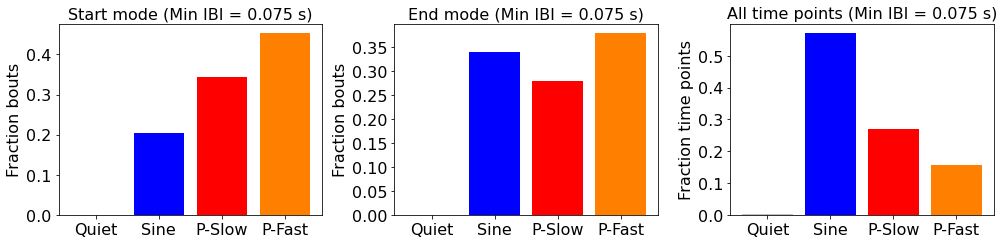

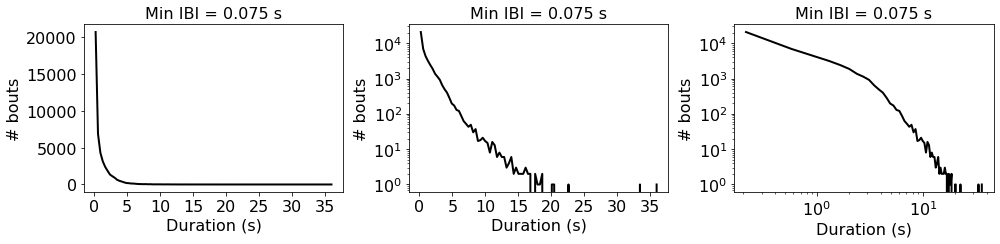

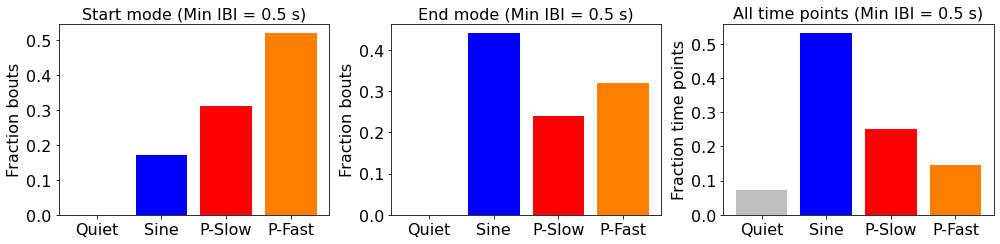

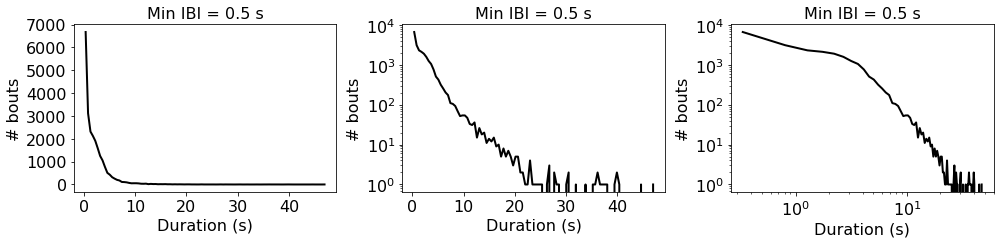

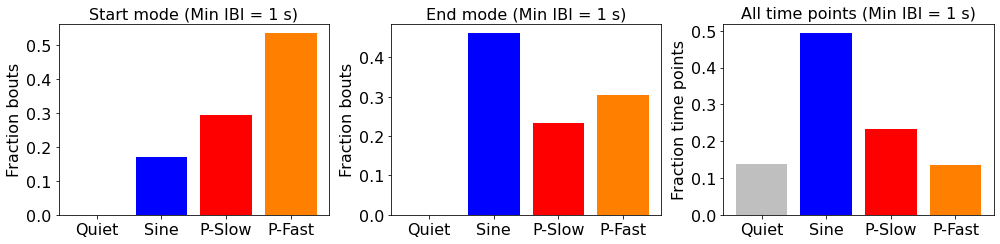

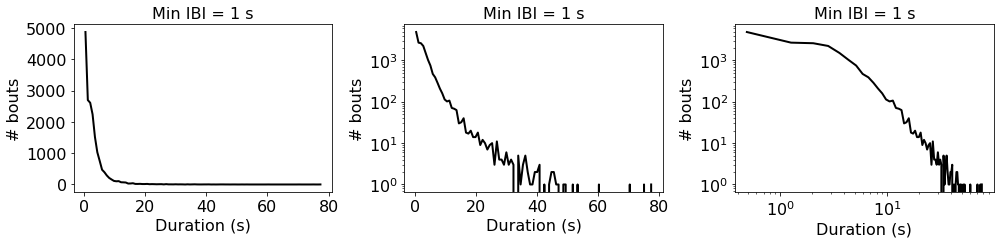

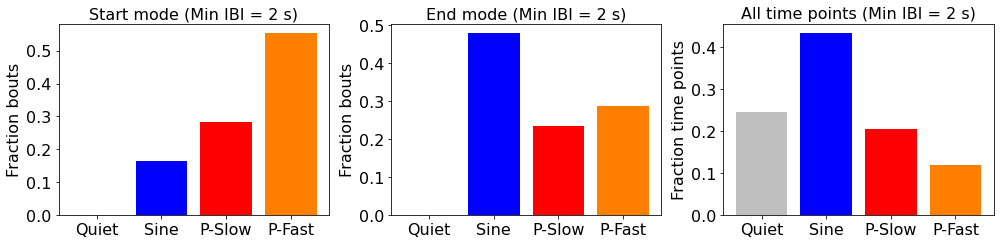

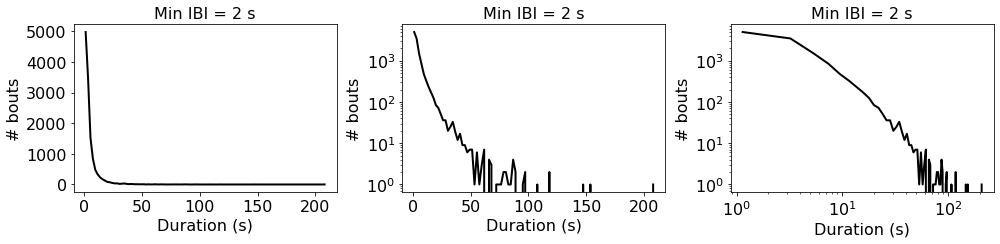

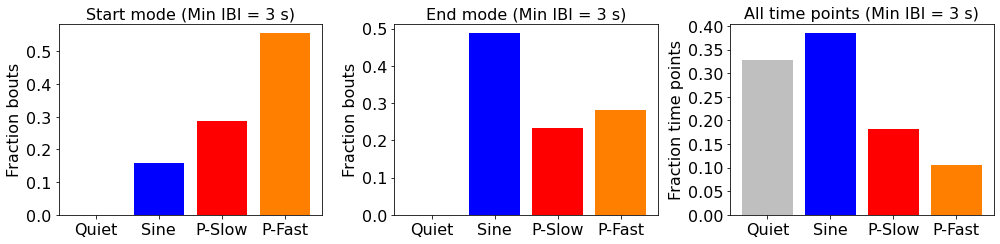

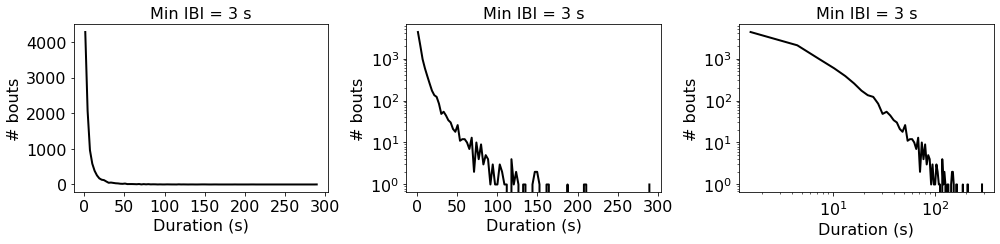

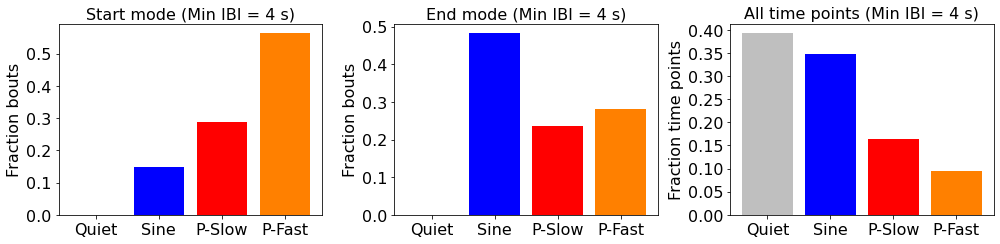

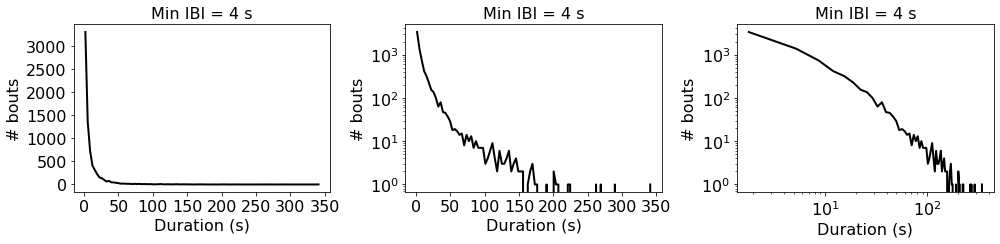

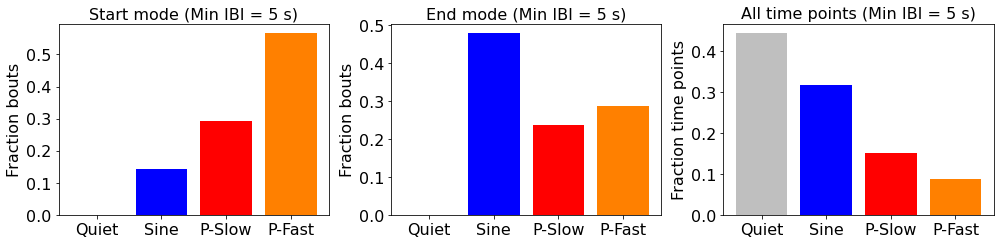

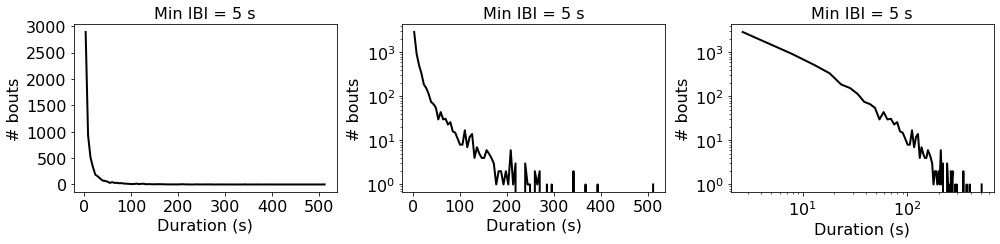

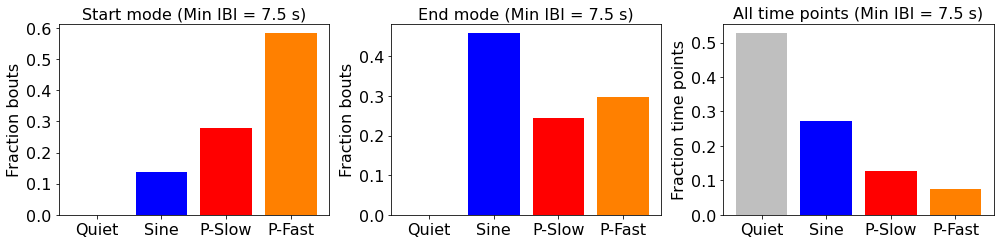

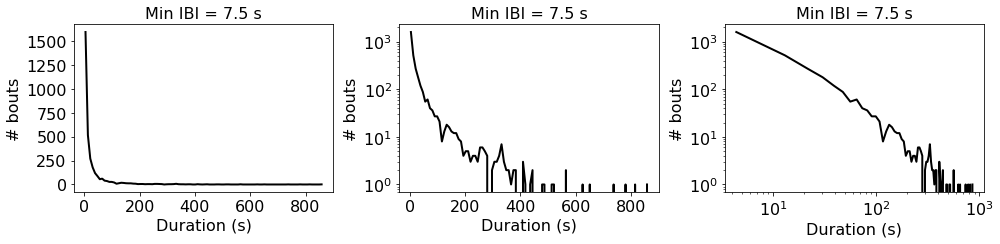

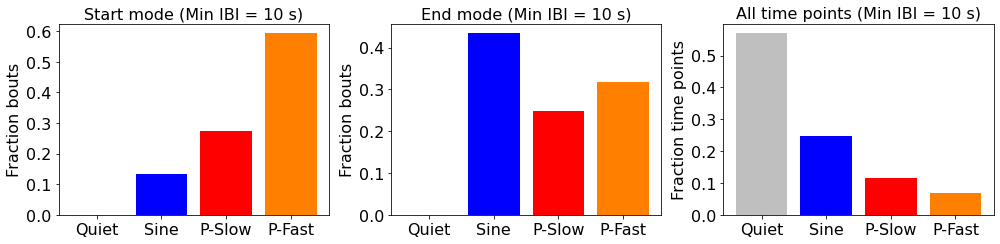

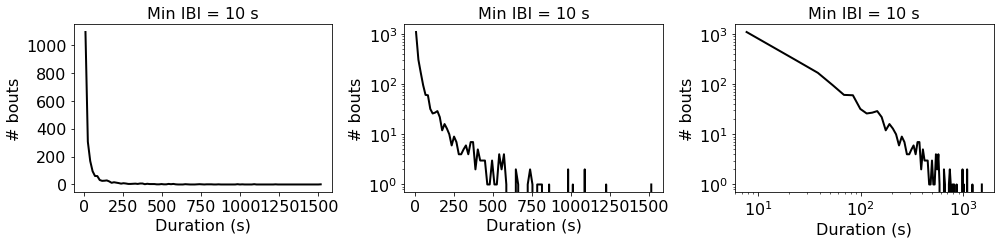

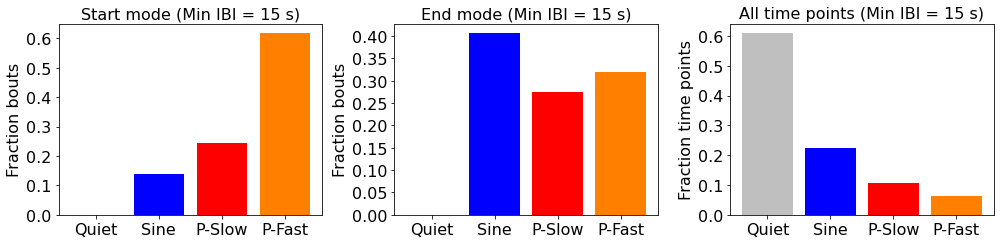

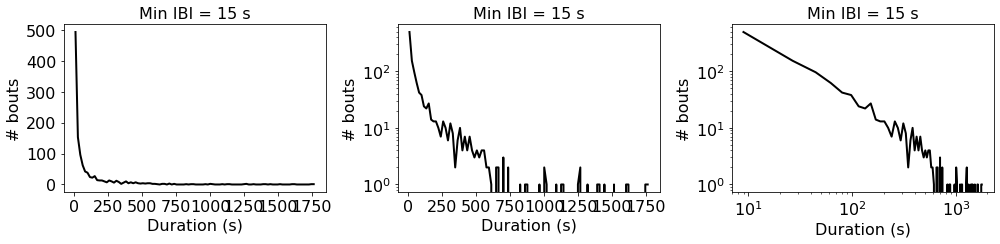

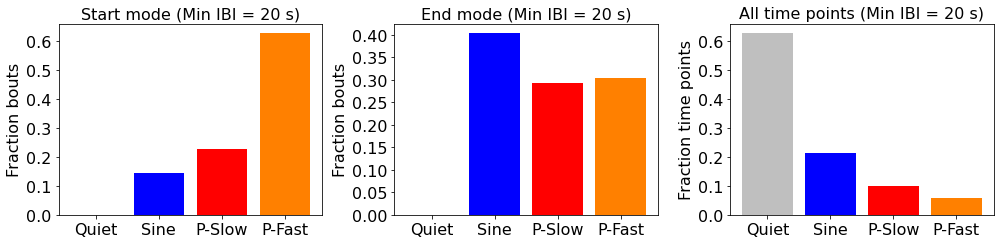

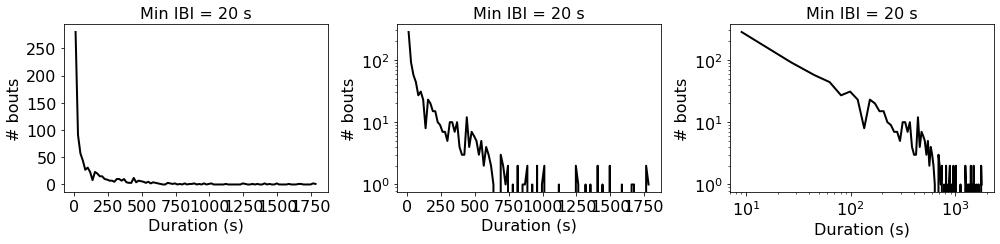

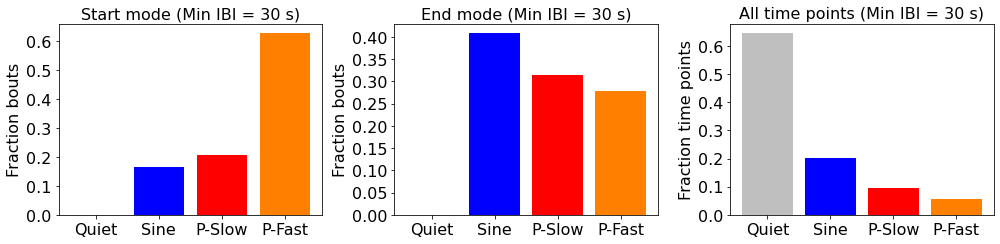

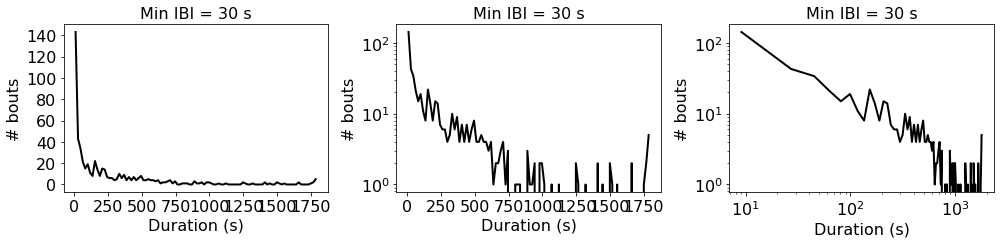

In [6]:
for ibi in [.075, .5, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 30]:

    iibi = int(round(ibi/dt))

    bts = []

    for s in songs:
        _, bt_edges = get_seg(s > 0, min_gap=iibi)
        bts.extend([s[lb:ub] for lb, ub in bt_edges])

    n_bt = len(bts)
    n_t_all = np.sum([len(bt) for bt in bts])
    print(f'{n_bt} bouts with {ibi} second minimum gap.')
    print(f'{n_t_all} time points in total.')

    # mode stats
    mode_start = np.array([bt[0] for bt in bts])
    mode_end = np.array([bt[-1] for bt in bts])

    n_mode_start = np.array([np.sum(mode_start == mode) for mode in range(4)])
    n_mode_end = np.array([np.sum(mode_end == mode) for mode in range(4)])
    n_mode_all = np.array([np.sum(cc(bts) == mode) for mode in range(4)])

    fig, axs = plt.subplots(1, 3, figsize=(14, 3.5), tight_layout=True)
    axs[0].bar(range(4), n_mode_start/n_bt, align='center', color=COLORS)
    axs[0].set_ylabel('Fraction bouts')
    axs[0].set_title(f'Start mode (Min IBI = {ibi} s)')

    axs[1].bar(range(4), n_mode_end/n_bt, align='center', color=COLORS)
    axs[1].set_ylabel('Fraction bouts')
    axs[1].set_title(f'End mode (Min IBI = {ibi} s)')

    axs[2].bar(range(4), n_mode_all/n_t_all, align='center', color=COLORS)
    axs[2].set_ylabel('Fraction time points')
    axs[2].set_title(f'All time points (Min IBI = {ibi} s)')

    for ax in axs:
        ax.set_xticks(range(4))
        ax.set_xticklabels(['Quiet', 'Sine', 'P-Slow', 'P-Fast'])
        set_font_size(ax, 16)
        
    # bout durations
    dur = np.array([len(bt) for bt in bts]) * dt
    ct_dur, bins_dur = np.histogram(dur, bins=100)
    binc_dur = .5*(bins_dur[:-1] + bins_dur[1:])
    
    fig, axs = plt.subplots(1, 3, figsize=(14, 3.5), tight_layout=True)
    axs[0].plot(binc_dur, ct_dur, lw=2, c='k')
    axs[1].semilogy(binc_dur, ct_dur, lw=2, c='k')
    axs[2].loglog(binc_dur, ct_dur, lw=2, c='k')
    
    for ax in axs:
        ax.set_xlabel('Duration (s)')
        ax.set_ylabel('# bouts')
        ax.set_title(f'Min IBI = {ibi} s')
    
    set_font_size(axs, 16)